#Fast OMP Implementation

In [1]:
%load_ext Cython

In [2]:
%%cython

"""Cython allows us to call lower level c-code instead of using Python. It can be a surprisingly big speedup!"""
import cython
from scipy.linalg.cython_blas cimport idamax, isamax, daxpy, dgemv, dtrmv, dcopy
from scipy.linalg.cython_lapack cimport dposv, dppsv, sppsv

ctypedef fused proj_t:
    double
    float

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef void ppsv(proj_t[:, :] As,
           proj_t[:, :, :] ys) nogil:
    # Works not for strided array I think. And please do not give a negative-stride array.
    cdef Py_ssize_t B = ys.shape[0]  # Batch size
    cdef int N = ys.shape[1]
    cdef int nrhs = ys.shape[2]
    cdef int info = 0  # Just discard any error signals ;)
    cdef char uplo = 85 # The letter 'U', since we store the lower triangle and fortran sees As.T.
    # cdef int ldb = ys[0].strides[0] // sizeof(double)

    for i from 0 <= i < B:
        if proj_t is double:  # One C-function is created for each of these specializations! :) (see argmax_blast.__signatures__)
            dppsv(&uplo, &N, &nrhs, &As[i, 0], &ys[i, 0, 0], &N, &info)
        elif proj_t is float:
            sppsv(&uplo, &N, &nrhs, &As[i, 0], &ys[i, 0, 0], &N, &info)


@cython.boundscheck(False)
@cython.wraparound(False)
cpdef void argmax_blast(proj_t[:, :] projections,
                 long long[:] output) nogil:
    # TODO: Numpy has its own indexing data-type - this may be a more appropriate output, and may even be faster.
    # http://conference.scipy.org/static/wiki/seljebotn_cython.pdf
    # https://apprize.best/python/cython/3.html
    cdef Py_ssize_t B = projections.shape[0]
    cdef int N = projections.shape[1]
    cdef int incx = projections.strides[1] // sizeof(proj_t)  # Stride between elements.
    cdef Py_ssize_t i
    for i from 0 <= i < B:
        if proj_t is double:
            output[i] = idamax(&N, &projections[i, 0], &incx) - 1
        elif proj_t is float:
            output[i] = isamax(&N, &projections[i, 0], &incx) - 1

In [3]:
"""This cell contains the code we've implemented. You should be able to call each function directly, or alternatively, see our example calls below"""

import os
import torch
import torch.utils
import torch.utils.data
from sklearn.datasets import make_sparse_coded_signal
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import OrthogonalMatchingPursuit
from contextlib import contextmanager
from timeit import default_timer
# from test_omp import omp_naive
# from test import *  # FIXME: better name
# from line_profiler import line_profiler

n_components, n_features = 100, 100
n_nonzero_coefs = 17
n_samples = 50

@contextmanager
def elapsed_timer():
    # https://stackoverflow.com/questions/7370801/how-to-measure-elapsed-time-in-python
    start = default_timer()
    elapser = lambda: default_timer() - start
    yield lambda: elapser()
    end = default_timer()
    elapser = lambda: end-start


def run_omp(X, y, n_nonzero_coefs, precompute=True, tol=0.0, normalize=False, fit_intercept=False, alg='naive'):
    if not isinstance(X, torch.Tensor):
        X = torch.as_tensor(X)
        y = torch.as_tensor(y)

    # We can either return sets, (sets, solutions), or xests
    # These are all equivalent, but are simply more and more dense representations.
    # Given sets and X and y one can (re-)construct xests. The second is just a sparse vector repr.

    # https://github.com/scikit-learn/scikit-learn/blob/15a949460dbf19e5e196b8ef48f9712b72a3b3c3/sklearn/linear_model/_omp.py#L690
    if fit_intercept or normalize:
        X = X.clone()
        assert not isinstance(precompute, torch.Tensor), "If user pre-computes XTX they can also pre-normalize X" \
                                                         " as well, so normalize and fit_intercept must be set false."

    if fit_intercept:
        X = X - X.mean(0)
        y = y - y.mean(1)[:, None]

    # To keep a good condition number on X, especially with Cholesky compared to LU factorization,
    # we should probably always normalize it (OMP is invariant anyways)
    if normalize is True:  # User can also just optionally supply pre-computed norms.
        normalize = (X * X).sum(0).sqrt()
        X /= normalize[None, :]

    if precompute is True or alg == 'v0':
        precompute = X.T @ X

    # If n_nonzero_coefs is equal to M, one should just return lstsq
    if alg == 'naive':
        sets, solutions, lengths = omp_naive(X, y, n_nonzero_coefs=n_nonzero_coefs, XTX=precompute, tol=tol)
    elif alg == 'v0':
        sets, solutions, lengths = omp_v0(X, y, n_nonzero_coefs=n_nonzero_coefs, XTX=precompute, tol=tol)


    solutions = solutions.squeeze(-1)
    if normalize is not False:
        solutions /= normalize[sets]

    xests = y.new_zeros(y.shape[0], X.shape[1])
    if lengths is None:
        xests[torch.arange(y.shape[0], dtype=sets.dtype, device=sets.device)[:, None], sets] = solutions
    else:
        for i in range(y.shape[0]):
            # xests[i].scatter_(-1, sets[i, :lengths[i]], solutions[i, :lengths[i]])
            xests[i, sets[i, :lengths[i]]] = solutions[i, :lengths[i]]

    return xests

def batch_mm(matrix, matrix_batch, return_contiguous=True):
    """
    :param matrix: Sparse or dense matrix, size (m, n).
    :param matrix_batch: Batched dense matrices, size (b, n, k).
    :return: The batched matrix-matrix product, size (m, n) x (b, n, k) = (b, m, k).
    """
    # One dgemm is faster than many dgemv.
    # From https://github.com/pytorch/pytorch/issues/14489#issuecomment-607730242
    batch_size = matrix_batch.shape[0]
    # Stack the vector batch into columns. (b, n, k) -> (n, b, k) -> (n, b*k)
    vectors = matrix_batch.transpose([1, 0, 2]).reshape(matrix.shape[1], -1)

    # A matrix-matrix product is a batched matrix-vector product of the columns.
    # And then reverse the reshaping. (m, n) x (n, b*k) = (m, b*k) -> (m, b, k) -> (b, m, k)
    if return_contiguous:
        result = np.empty_like(matrix_batch, shape=(batch_size, matrix.shape[0], matrix_batch.shape[2]))
        np.matmul(matrix, vectors, out=result.transpose([1, 0, 2]).reshape(matrix.shape[0], -1))
    else:
        result = (matrix @ vectors).reshape(matrix.shape[0], batch_size, -1).transpose([1, 0, 2])

    return result


def innerp(x, y=None, out=None):
    if y is None:
        y = x
    if out is not None:
        out = out[:, None, None]  # Add space for two singleton dimensions.
    return torch.matmul(x[..., None, :], y[..., :, None], out=out)[..., 0, 0]

def cholesky_solve(ATA, ATy):
    if ATA.dtype == torch.half or ATy.dtype == torch.half:
        return ATy.to(torch.float).cholesky_solve(torch.cholesky(ATA.to(torch.float))).to(ATy.dtype)
    return ATy.cholesky_solve(torch.cholesky(ATA)).to(ATy.dtype)


def omp_naive(X, y, n_nonzero_coefs, tol=None, XTX=None):
    on_cpu = not (y.is_cuda or y.dtype == torch.half)
    # torch.cuda.synchronize()
    # Given X as an MxN array and y as an BxN array, do omp to approximately solve Xb=y

    # Base variables
    XT = X.contiguous().t()  # Store XT in fortran-order.
    y = y.contiguous()
    r = y.clone()

    sets = y.new_zeros((n_nonzero_coefs, y.shape[0]), dtype=torch.long).t()
    if tol:
        result_sets = sets.new_zeros(y.shape[0], n_nonzero_coefs)
        result_lengths = sets.new_zeros(y.shape[0])
        result_solutions = y.new_zeros((y.shape[0], n_nonzero_coefs, 1))
        original_indices = torch.arange(y.shape[0], dtype=sets.dtype, device=sets.device)

    # Trade b*k^2+bk+bkM = O(bkM) memory for much less compute time. (This has to be done anyways since we are batching,
    # otherwise one could just permute columns of X in-place as in https://github.com/scikit-learn/scikit-learn/blob/15a949460dbf19e5e196b8ef48f9712b72a3b3c3/sklearn/linear_model/_omp.py#L28 )
    ATs = y.new_zeros(r.shape[0], n_nonzero_coefs, X.shape[0])
    ATys = y.new_zeros(r.shape[0], n_nonzero_coefs, 1)
    ATAs = torch.eye(n_nonzero_coefs, dtype=y.dtype, device=y.device)[None].repeat(r.shape[0], 1, 1)
    if on_cpu:
        # For CPU it is faster to use a packed representation of the lower triangle in ATA.
        tri_idx = torch.tril_indices(n_nonzero_coefs, n_nonzero_coefs, device=sets.device, dtype=sets.dtype)
        ATAs = ATAs[:, tri_idx[0], tri_idx[1]]

    solutions = y.new_zeros((r.shape[0], 0))

    for k in range(n_nonzero_coefs+bool(tol)):
        # STOPPING CRITERIA
        if tol:
            problems_done = innerp(r) <= tol
            if k == n_nonzero_coefs:
                problems_done[:] = True

            if problems_done.any():
                remaining = ~problems_done

                orig_idxs = original_indices[problems_done]
                result_sets[orig_idxs, :k] = sets[problems_done, :k]
                result_solutions[orig_idxs, :k] = solutions[problems_done]
                result_lengths[orig_idxs] = k
                original_indices = original_indices[remaining]

                # original_indices = original_indices[remaining]
                ATs = ATs[remaining]
                ATys = ATys[remaining]
                ATAs = ATAs[remaining]
                sets = sets[remaining]
                y = y[remaining]
                r = r[remaining]
                if problems_done.all():
                    return result_sets, result_solutions, result_lengths
        # GET PROJECTIONS AND INDICES TO ADD
        if on_cpu:
            projections = batch_mm(XT.numpy(), r[:, :, None].numpy())
            argmax_blast(projections.squeeze(-1), sets[:, k].numpy())
        else:
            projections = XT @ r[:, :, None]
            sets[:, k] = projections.abs().sum(-1).argmax(-1)  # Sum is just a squeeze, but would be relevant in SOMP.

        # UPDATE AT
        AT = ATs[:, :k + 1, :]
        updateA = XT[sets[:, k], :]
        AT[:, k, :] = updateA

        # UPDATE ATy based on AT
        ATy = ATys[:, :k + 1]
        innerp(updateA, y, out=ATy[:, k, 0])

        # UPDATE ATA based on AT or precomputed XTX.
        if on_cpu:
            packed_idx = k * (k - 1) // 2
            if XTX is not None:  # Update based on precomputed XTX.
                ATAs.t()[k + packed_idx:packed_idx + 2 * k + 1, :].t().numpy()[:] = XTX[sets[:, k, None], sets[:, :k + 1]]
            else:
                np.matmul(AT[:, :k + 1, :].numpy(), updateA[:, :, None].numpy(),
                          out=ATAs.t()[k + packed_idx:packed_idx + 2 * k + 1, :].t()[:, :, None].numpy())
        else:
            ATA = ATAs[:, :k + 1, :k + 1]
            if XTX is not None:
                ATA[:, k, :k + 1] = XTX[sets[:, k, None], sets[:, :k + 1]]
            else:
                # Update ATAs by adding the new column of inner products.
                torch.bmm(AT[:, :k + 1, :], updateA[:, :, None], out=ATA[:, k, :k + 1, None])

        # SOLVE ATAx = ATy.
        if on_cpu:
            solutions = ATy.permute(0, 2, 1).clone().permute(0, 2, 1)  # Get a copy.
            ppsv(ATAs.t()[:packed_idx + 2 * k + 1, :].t().contiguous().numpy(), solutions.numpy())
        else:
            ATA[:, :k, k] = ATA[:, k, :k]  # Copy lower triangle to upper triangle.
            solutions = cholesky_solve(ATA, ATy)

        # FINALLY, GET NEW RESIDUAL r=y-Ax
        if on_cpu:
            np.subtract(y.numpy(), (AT.permute(0, 2, 1).numpy() @ solutions.numpy()).squeeze(-1), out=r.numpy())
        else:
            torch.baddbmm(y[:, :, None], AT.permute(0, 2, 1), solutions, beta=-1, out=r[:, :, None])

    return sets, solutions, None

def omp_v0(X, y, XTX, n_nonzero_coefs=None, tol=None, inverse_cholesky=True):
    B = y.shape[0]
    normr2 = innerp(y)  # Norm squared of residual.
    projections = (X.transpose(1, 0) @ y[:, :, None]).squeeze(-1)
    sets = y.new_zeros(n_nonzero_coefs, B, dtype=torch.int64)

    if inverse_cholesky:
        # Doing the inverse-cholesky iteratively uses more memory,
        # but takes less time than waiting till solving the problem in the end it seems.
        # (Since F is triangular it could be __even faster__ to multiply, prob. not on GPU tho.)
        F = torch.eye(n_nonzero_coefs, dtype=y.dtype, device=y.device).repeat(B, 1, 1)
        a_F = y.new_zeros(n_nonzero_coefs, B, 1)

    D_mybest = y.new_empty(B, n_nonzero_coefs, XTX.shape[0])
    temp_F_k_k = y.new_ones((B, 1))

    if tol:
        result_lengths = sets.new_zeros(y.shape[0])
        result_solutions = y.new_zeros((y.shape[0], n_nonzero_coefs, 1))
        finished_problems = sets.new_zeros(y.shape[0], dtype=torch.bool)

    for k in range(n_nonzero_coefs+bool(tol)):
        # STOPPING CRITERIA
        if tol:
            problems_done = normr2 <= tol
            if k == n_nonzero_coefs:
                problems_done[:] = True

            if problems_done.any():
                new_problems_done = problems_done & ~finished_problems
                finished_problems.logical_or_(problems_done)
                result_lengths[new_problems_done] = k
                if inverse_cholesky:
                    result_solutions[new_problems_done, :k] = F[new_problems_done, :k, :k].permute(0, 2, 1) @ a_F[:k, new_problems_done].permute(1, 0, 2)
                else:
                    assert False, "inverse_cholesky=False with tol != None is not handled yet"
                if problems_done.all():
                    return sets.t(), result_solutions, result_lengths

        sets[k] = projections.abs().argmax(1)
        # D_mybest[:, k, :] = XTX[gamma[k], :]  # Same line as below, but significantly slower. (prob. due to the intermediate array creation)
        torch.gather(XTX, 0, sets[k, :, None].expand(-1, XTX.shape[1]), out=D_mybest[:, k, :])
        if k:
            D_mybest_maxindices = D_mybest.permute(0, 2, 1)[torch.arange(D_mybest.shape[0], dtype=sets.dtype, device=sets.device), sets[k], :k]
            torch.rsqrt(1 - innerp(D_mybest_maxindices),
                        out=temp_F_k_k[:, 0])  # torch.exp(-1/2 * torch.log1p(-inp), temp_F_k_k[:, 0])
            D_mybest_maxindices *= -temp_F_k_k  # minimal operations, exploit linearity
            D_mybest[:, k, :] *= temp_F_k_k
            D_mybest[:, k, :, None].baddbmm_(D_mybest[:, :k, :].permute(0, 2, 1), D_mybest_maxindices[:, :, None])


        temp_a_F = temp_F_k_k * torch.gather(projections, 1, sets[k, :, None])
        normr2 -= (temp_a_F * temp_a_F).squeeze(-1)
        projections -= temp_a_F * D_mybest[:, k, :]
        if inverse_cholesky:
            a_F[k] = temp_a_F
            if k:  # Could maybe get a speedup from triangular mat mul kernel.
                torch.bmm(D_mybest_maxindices[:, None, :], F[:, :k, :], out=F[:, k, None, :])
                F[:, k, k] = temp_F_k_k[..., 0]
    else: # FIXME: else branch will not execute if n_nonzero_coefs=0, so solutions is undefined.
        # Normal exit, used when tolerance=None.
        if inverse_cholesky:
            solutions = F.permute(0, 2, 1) @ a_F.squeeze(-1).transpose(1, 0)[:, :, None]
        else:
            # Solving the problem in the end without using inverse Cholesky.
            AT = X.T[sets.T]
            solutions = cholesky_solve(AT @ AT.permute(0, 2, 1), AT @ y.T[:, :, None])

    return sets.t(), solutions, None



# Definitions

In [1]:
!pip install transformers
import torch
from torch import nn
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import classification_report
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
from transformers import logging
logging.set_verbosity_error()

import sklearn
from sklearn.linear_model import OrthogonalMatchingPursuit

from google.colab import drive
drive.mount('/content/drive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

STATE_PATH = '/content/drive/MyDrive/NLP-Final/bert_state_w_finetuning'
KEYS_VALUES_PATH = "/content/drive/My Drive/NLP-Final/bert_sparse_keys&values/"

     |████████████████████████████████| 4.0 MB 8.0 MB/s 
     |████████████████████████████████| 6.6 MB 32.0 MB/s 
     |████████████████████████████████| 596 kB 60.1 MB/s 
     |████████████████████████████████| 895 kB 63.1 MB/s 
     |████████████████████████████████| 77 kB 9.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Mounted at /content/drive
cuda


In [ ]:
path = '/content/drive/MyDrive/NLP-Final/'

train_data = pd.read_csv(path + 'train.csv')
test_data = pd.read_csv(path + 'test.csv')

In [ ]:
train_data = train_data[:2000]
test_data = test_data[:500]

train_data = train_data.to_dict(orient='records')
test_data = test_data.to_dict(orient='records')
type(train_data)

train_texts, train_labels = list(zip(*map(lambda d: (d['text'], d['sentiment']), train_data)))
test_texts, test_labels = list(zip(*map(lambda d: (d['text'], d['sentiment']), test_data)))

len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(2000, 2000, 500, 500)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], test_texts))
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")

train_y = np.array(train_labels) == 'pos'
test_y = np.array(test_labels) == 'pos'

train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
unique, counts = np.unique(test_y, return_counts=True)
dict(zip(unique, counts))

{False: 246, True: 254}

In [5]:
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        output = self.bert(tokens, attention_mask=masks)
        pooled_output = output.pooler_output
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        return proba

In [ ]:
# bert_clf = BertBinaryClassifier()
# bert_clf = bert_clf.cuda()
# x = torch.tensor(train_tokens_ids[:3]).to(device)
# y, pooled = bert_clf.bert(x)
# y = bert_clf(x)

In [ ]:
BATCH_SIZE = 16
EPOCHS = 10

train_tokens_tensor = torch.tensor(train_tokens_ids)
train_y_tensor = torch.tensor(train_y.reshape(-1, 1)).float()

test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

train_masks_tensor = torch.tensor(train_masks)
test_masks_tensor = torch.tensor(test_masks)

train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
def train_model(model):
  param_optimizer = list(model.sigmoid.named_parameters()) 
  optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
  optimizer = Adam(model.parameters(), lr=3e-6)
  torch.cuda.empty_cache()   # Clearing Cache space for a fresh Model run

  for epoch_num in range(EPOCHS):
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
        print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')
        logits = model(token_ids, masks)
        
        loss_func = nn.BCELoss()

        batch_loss = loss_func(logits, labels)
        train_loss += batch_loss.item()
        
        model.zero_grad()
        batch_loss.backward()

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        
        clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_data) / BATCH_SIZE, train_loss / (step_num + 1)))
  return model

In [ ]:
def eval_model(model):
  model.eval().to(device)
  model_predicted = []
  all_logits = []
  with torch.no_grad():
      for step_num, batch_data in enumerate(test_dataloader):
          token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

          logits = model(token_ids, masks)
          loss_func = nn.BCELoss()
          loss = loss_func(logits, labels)
          numpy_logits = logits.cpu().detach().numpy()
          
          model_predicted += list(numpy_logits[:, 0] > 0.5)
          all_logits += list(numpy_logits[:, 0])

          token_ids, masks, labels = tuple(t.to("cpu") for t in batch_data) # PATCH- move back to cpu

  
  report = classification_report(test_y, model_predicted, output_dict=True)
  model.to("cpu")
  return report

In [ ]:
def convert_model_state_to_zeros(model, model_state):
  # print(st)
  for name,x in model.named_parameters():
  #  if "intermediate.dense" in name  or "output.dense" in name:
  # if "intermediate.dense" in name or "output.dense" in name: # intermidiate is the feed forward part of the layer 
      model_state[name]  = model_state[name]*0
  return model_state

In [ ]:
def print_layers_params(model, model_state):
  # print(st)
  for name,x in model.named_parameters():
  #  if "intermediate.dense" in name  or "output.dense" in name:
    if "intermediate.dense" in name: # intermidiate is the feed forward part of the layer 
      print(model_state[name])

# print_layers_params(bert_clf, bert_clf.state_dict())

# Sparse-Keys Analysis

In [ ]:
from numpy import savetxt
LAYER_NUM = 11

# Load fine-tuned BERT
bert_sparse = BertBinaryClassifier()
bert_sparse = bert_sparse.cuda()
bert_sparse.load_state_dict(torch.load(STATE_PATH))

# Get embeddings and BERT state
embeddings = bert_sparse.bert.get_input_embeddings()
E = embeddings.weight.detach().to(device)
bert1_st = bert_sparse.bert.state_dict() # Bert model state dictionary

# Compute sparse keys
keys = bert1_st[f"encoder.layer.{LAYER_NUM}.intermediate.dense.weight"].detach().to(device)
n_non_zero_keys = max(int(0.3 * keys.shape[0]), 1)
sparse_keys = run_omp(E.T,  keys, n_non_zero_keys) # run optimized OMP
savetxt(KEYS_VALUES_PATH+f"layer{LAYER_NUM}_keys.csv", sparse_keys, delimiter=',')

# Compute sparse values
values = bert1_st[f"encoder.layer.{LAYER_NUM}.output.dense.weight"].detach().to(device)
n_non_zero_values = max(int(0.3 * values.shape[1]), 1)
sparse_values = run_omp(E.T,  values.T, n_non_zero_values) # run optimized OMP
savetxt(KEYS_VALUES_PATH+f"layer{LAYER_NUM}_values.csv", sparse_keys, delimiter=',')

In [ ]:
from numpy import loadtxt
LAYER_NUM = 11

sparse_keys = loadtxt(KEYS_VALUES_PATH+f"layer{LAYER_NUM}_keys.csv", delimiter=',').astype("double")
sparse_keys = torch.from_numpy(sparse_keys).to(device)
sparse_values = loadtxt(KEYS_VALUES_PATH+f"layer{LAYER_NUM}_values.csv", delimiter=',').astype("double")
sparse_values = torch.from_numpy(sparse_values).to(device)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

for i in range(100):
  # non_zero_keys = torch.nonzero(sparse_keys[i])
  sorted_keys, indices_keys = torch.sort(torch.abs(sparse_keys[i]), descending=True)
  print(tokenizer.batch_decode(indices_keys[0:10]))

  # non_zero_values = torch.nonzero(sparse_values[i])
  sorted_values, indices_values = torch.sort(torch.abs(sparse_values[i]), descending=True)
  print(tokenizer.batch_decode(indices_values[0:10]))
  # print(tokenizer.batch_decode(non_zero_values))
  print("#################################################")

In [ ]:
from numpy import loadtxt

layer_num = 11

# load the sparse keys and values, that were computed by the OMP
sparse_keys = loadtxt(KEYS_VALUES_PATH+f"layer{layer_num}_keys.csv", delimiter=',').astype("double")
sparse_keys = torch.from_numpy(sparse_keys)
sparse_values = loadtxt(KEYS_VALUES_PATH+f"layer{layer_num}_values.csv", delimiter=',').astype("double")
sparse_values = torch.from_numpy(sparse_values)

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

for i in range(100):
  sorted_keys, indices_keys = torch.sort(torch.abs(sparse_keys[i]), descending=True)
  print(bert_tokenizer.batch_decode(indices_keys[0:10]))

  sorted_values, indices_values = torch.sort(torch.abs(sparse_values[i]), descending=True)
  print(bert_tokenizer.batch_decode(indices_values[0:10]))
  print("#################################################")

# #####RUN ALL BEFORE THIS LINE !! - CLICK "RUN BEFORE" ON THIS CELL //Ctrl+F8

---



# Experiment - No Need for now

In [ ]:
# regular eval
bert_regular = BertBinaryClassifier()
# bert_regular = bert_regular.cuda()
regular_st = bert_regular.state_dict()
print(regular_st["bert.encoder.layer.0.intermediate.dense.weight"])

# model= train_model(bert_regular)
# regular_st = bert_regular.state_dict()
# print(regular_st["bert.encoder.layer.0.intermediate.dense.weight"])

# eval_model(bert_regular)

tensor([[-0.0101, -0.0017,  0.0130,  ..., -0.0537,  0.0137, -0.0192],
        [-0.0604,  0.0104,  0.0648,  ..., -0.0486, -0.0277,  0.0070],
        [-0.0147,  0.0428,  0.0398,  ..., -0.0082,  0.0114, -0.0275],
        ...,
        [-0.0500, -0.0660,  0.0270,  ..., -0.0131,  0.0041,  0.0068],
        [ 0.0448, -0.0237,  0.0167,  ...,  0.0035,  0.0069,  0.0205],
        [-0.0094,  0.0363,  0.0258,  ..., -0.0086,  0.0064,  0.0604]])


In [ ]:
# # save BERT's state after finetuning
# STATE_PATH = '/content/drive/MyDrive/NLP-Final/bert_state_w_finetuning'
# regular_st = bert_regular.state_dict()
# torch.save(regular_st, STATE_PATH)

In [ ]:
# bert_check = BertBinaryClassifier()
# bert_check = bert_check.cuda()
# bert_check.load_state_dict(torch.load(STATE_PATH))
# eval_model(bert_check)

In [ ]:
# # convert ff params to zeros and eval
# bert_zeros = BertBinaryClassifier()
# bert_zeros = bert_zeros.cuda()
# zeros_st = convert_model_state_to_zeros(bert_zeros, bert_zeros.state_dict())
# bert_zeros.load_state_dict(zeros_st)
# zeros_st = bert_zeros.state_dict()
# print(zeros_st["bert.encoder.layer.0.intermediate.dense.weight"])
# print(zeros_st["bert.encoder.layer.0.output.dense.weight"])
# eval_model(bert_zeros) # eval

# Sparsity with SKlearn

In [ ]:
bert_sparse = BertBinaryClassifier()
bert_sparse = bert_sparse.cuda()
bert_sparse.load_state_dict(torch.load(STATE_PATH))
# eval_model(bert_sparse)

# find x that minimize ||keys - Embeddings*x||, given sparsity level for x
# meaning, the best approx for: keys = E*x
# replace this x with original keys
emb = bert_sparse.bert.get_input_embeddings()
bert_sparse_st = bert_sparse.bert.state_dict()

X = emb.weight.cpu().detach().numpy()
y = bert_sparse_st["encoder.layer.0.intermediate.dense.weight"].cpu().detach().numpy()
print(type(X))
print(type(y))

n_features = X.shape[1]
n_non_zero = max(int(0.1 * n_features), 1)

mp = OrthogonalMatchingPursuit(normalize=False).fit(X.T, y.T)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  X, y[:, k], n_nonzero_coefs, tol, copy_X=copy_X, return_path=return_path


KeyboardInterrupt: ignored

In [ ]:
# save mp!!!
print(mp)
print(mp.size())

# Replace! + save mp!
bert_sparse_st["encoder.layer.0.intermediate.dense.weight"] = mp
bert_sparse.bert.load_state_dict(bert_sparse_st)
bert_sparse_st = bert_sparse.state_dict()
torch.save(bert_sparse_st, '/content/drive/MyDrive/NLP-Final/bert_state_w_mp_0.1')
eval_model(bert_sparse)

# Sparsity with OMP - DEV and CHECK

In [ ]:
bert1 = BertBinaryClassifier()
bert1.load_state_dict(torch.load(STATE_PATH))


In [ ]:
bert1 = BertBinaryClassifier()
bert1 = bert1.cuda()
bert1.load_state_dict(torch.load(STATE_PATH))

emb1 = bert1.bert.get_input_embeddings()
bert1_st = bert1.bert.state_dict()

X = emb1.weight.cpu().detach().to(device)
y = bert1_st["encoder.layer.0.attention.output.dense.weight"].detach().to(device)

n_features = X.shape[1]
n_non_zero = max(int(0.1 * n_features), 1)

xes = run_omp(X.T,  y.T, n_non_zero,alg='v0')

In [ ]:
xes.size()
bert1_st["encoder.layer.0.attention.output.dense.weight"] = xes
bert1.bert.load_state_dict(bert1_st)
eval_model(bert1)

In [ ]:
y = bert1_st["encoder.layer.2.intermediate.dense.weight"].cpu().numpy()


In [ ]:
import sklearn
from sklearn.linear_model import OrthogonalMatchingPursuit
print(X.shape)
print(y.shape)
mp = OrthogonalMatchingPursuit(normalize=False).fit(X.T.cpu(), y.T)


In [ ]:
# no replace
eval_model(bert1)

In [ ]:
# layer 2 intermediate replace
j = mp.predict(X.T.cpu())
bert1_st["encoder.layer.2.intermediate.dense.weight"]  = torch.Tensor(j.T)
bert1.bert.load_state_dict(bert1_st)
eval_model(bert1)

In [ ]:
torch.save(bert1, '/content/drive/MyDrive/NLP-Final/bert_state_layer2_intermediate_sparse')
# torch.save(bert1, '/content/drive/MyDrive/NLP-Final/bert_state_layer0_attention_output_dense_sparse')


In [ ]:
# attention output replace
j = mp.predict(X.T.cpu())
bert1_st["encoder.layer.0.attention.output.dense.weight"]  = torch.Tensor(j.T)
bert1.bert.load_state_dict(bert1_st)
eval_model(bert1)

In [ ]:
# bert1.to("cpu")
torch.cuda.empty_cache()

emb1 = bert1.bert.get_input_embeddings()
bert1_st = bert1.bert.state_dict()

X_tensor = emb1.weight.detach().to(device)
y_tensor = bert1_st["encoder.layer.2.intermediate.dense.weight"].detach().to(device)

num_features = X_tensor.shape[1]
n_non_zero = max(int(0.1 * num_features), 1)

# xes = run_omp(X_tensor.T.cpu(),  y_tensor.cpu(), n_non_zero, alg='v0')
xes = run_omp(X_tensor.T,  y_tensor, n_non_zero)


In [ ]:
(xes @ X_tensor).shape

In [ ]:
# layer 2 intermediate replace - OMP FAST
j = xes @ X_tensor
bert1_st["encoder.layer.2.intermediate.dense.weight"]  = j
bert1.bert.load_state_dict(bert1_st)
eval_model(bert1)

# #####Run only one of the sections Below due to GPU Memory Runout



---


#10% of Coefficients are Non-zero - TESTS

**BERT Test - Replace each layer independently**

```
    bert1_st = bert1.bert.state_dict() # Bert model state dictionary
    y_tensor = bert1_st[f"encoder.layer.{i-1}.intermediate.dense.weight"].detach().to(device) # get weights for ith ff layer

```



In [ ]:
# Replace every state untouching the others
emb1 = bert1.bert.get_input_embeddings() # embeddings
bert1_st = bert1.bert.state_dict() # Bert model state dictionary

X_tensor = emb1.weight.detach().to(device) 
num_features = X_tensor.shape[1]
n_non_zero = max(int(0.1 * num_features), 1) # 10% of X num of features

exp_results = dict()


for i in range(13):
  torch.cuda.empty_cache() # Clear memory
  bert1.load_state_dict(torch.load(STATE_PATH)) # load first the original weights

  if i == 0:
    print("Results Before Replacement")
    res = eval_model(bert1)
    exp_results[f'No_Replace'] = res
    continue

  bert1_st = bert1.bert.state_dict() # Bert model state dictionary
  y_tensor = bert1_st[f"encoder.layer.{i-1}.intermediate.dense.weight"].detach().to(device) # get weights for ith ff layer

  xes = run_omp(X_tensor.T,  y_tensor, n_non_zero) # run fast OMP

  temp_weights = xes @ X_tensor # matrix mult to get the weights

  bert1_st[f"encoder.layer.{i-1}.intermediate.dense.weight"]  = temp_weights
  bert1.bert.load_state_dict(bert1_st)
  print(f"Results for layer-{i-1} Weights Replacement")
  res = eval_model(bert1)
  exp_results[f'layer-{i-1}'] = res


  y_tensor.to("cpu")

# pd.DataFrame.from_dict(exp_results).to_excel(f'/content/drive/MyDrive/NLP-Final/experiments_results/BERT/Replace_each_layer_leaving_others_untouched.xlsx')

Results Before Replacement


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).transpose(-2, -1).conj().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1285.)


Results for layer-0 Weights Replacement


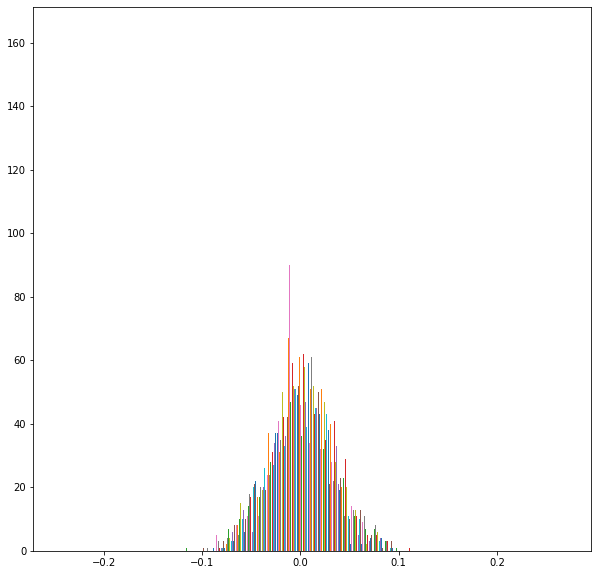

In [ ]:
import matplotlib.pyplot as plt
# Plot the keys as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(temp_weights.cpu(), bins=100)
plt.show()

In [ ]:
# count vector frequencies
k = np.zeros(temp_weights.shape[1])
for index in temp_weights.nonzero():
  k[index[1]] += 1


In [ ]:
temp_weights.nonzero().shape

torch.Size([2359296, 2])

**BERT Test - Replace layers one by one together**

```
    y_tensor = bert1_st[f"encoder.layer.{i-1}.intermediate.dense.weight"].detach().to(device) # get weights for ith ff layer

```


In [ ]:
#  Replace layers one by one together
emb1 = bert1.bert.get_input_embeddings() # embeddings
bert1_st = bert1.bert.state_dict() # Bert model state dictionary

X_tensor = emb1.weight.detach().to(device) 
num_features = X_tensor.shape[1]

ratios = [0.01,0.02,0.05,0.1,0.15,0.2,0.25]
for j in ratios:
  n_non_zero = max(int(j * num_features), 1)+1 # 10% of X num of features

  print(f'{100*j:.2f}% Sparsity - {n_non_zero} coef.')
  exp_results = dict()
  for i in range(13):
    torch.cuda.empty_cache() # Clear memory
    bert1.load_state_dict(torch.load(STATE_PATH)) # load first the original weights

    if i == 0:
      print("Results Before Replacement")
      res = eval_model(bert1)
      exp_results[f'No_Replace'] = res
      continue

    # bert1_st is updated every step
    y_tensor = bert1_st[f"encoder.layer.{i-1}.intermediate.dense.weight"].detach().to(device) # get weights for ith ff layer

    xes = run_omp(X_tensor.T,  y_tensor, n_non_zero) # run fast OMP

    temp_weights = xes @ X_tensor # matrix mult to get the weights

    bert1_st[f"encoder.layer.{i-1}.intermediate.dense.weight"]  = temp_weights
    bert1.bert.load_state_dict(bert1_st)
    print(f"Results for Replacing all the layers up to layer-{i-1} (included) ")
    res = eval_model(bert1)
    exp_results[f'layer0_to_{i}'] = res

  pd.DataFrame.from_dict(exp_results).to_excel(f'/content/drive/MyDrive/NLP-Final/experiments_results/BERT/Replace_layers_one_by_one_{100*j:.2f}_percent_{n_non_zero}_coef.xlsx')

1.00% Sparsity - 8 coef.
Results Before Replacement
Results for Replacing all the layers up to layer-0 (included) 
Results for Replacing all the layers up to layer-1 (included) 
Results for Replacing all the layers up to layer-2 (included) 


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Replacing all the layers up to layer-3 (included) 


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Replacing all the layers up to layer-4 (included) 


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Replacing all the layers up to layer-5 (included) 


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Replacing all the layers up to layer-6 (included) 


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Replacing all the layers up to layer-7 (included) 
Results for Replacing all the layers up to layer-8 (included) 


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Replacing all the layers up to layer-9 (included) 


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Replacing all the layers up to layer-10 (included) 


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Replacing all the layers up to layer-11 (included) 


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2.00% Sparsity - 16 coef.
Results Before Replacement


RuntimeError: ignored

#Different Sparsity Levels - Run Alone - No GPU Memory for all the EXP together - TESTS

**BERT Test - Replace only for layer 0 and change num of Non Zero Coefficients**


```
  # Change ratio of non_zero_coef each iteration
  n_non_zero = max(int(ratio * num_features), 1) # ratio of X num of features
```



In [ ]:
# 1%-45%
import gc 
emb1 = bert1.bert.get_input_embeddings() # embeddings
bert1_st = bert1.bert.state_dict() # Bert model state dictionary

X_tensor = emb1.weight.detach().to(device) 
num_features = X_tensor.shape[1]


ratios = [0.0,0.01,0.05,0.1,0.15,0.2,0.3,0.35,0.4,0.45]

for j in range (12):
  gc.collect()
  exp_results = dict()
  for i, ratio in enumerate(ratios):
    # Change ratio of non_zero_coef each iteration
    n_non_zero = max(int(ratio * num_features), 1) # ratio of X num of features
    torch.cuda.empty_cache() # Clear memory
    
    bert1.load_state_dict(torch.load(STATE_PATH)) # load first the original weights

    if i == 0: # print baseline results first
      print("Results Before Replacement")
      eval_model(bert1)
      continue

    bert1_st = bert1.bert.state_dict() # Bert model state dictionary
    y_tensor = bert1_st[f"encoder.layer.{j}.intermediate.dense.weight"].detach().to(device) # get weights for ith ff layer

    xes = run_omp(X_tensor.T,  y_tensor, n_non_zero) # run fast OMP

    temp_weights = xes @ X_tensor # matrix mult to get the weights

    bert1_st[f"encoder.layer.{j}.intermediate.dense.weight"]  = temp_weights
    bert1.bert.load_state_dict(bert1_st)
    print(f"Results for layer-{j} Weights Replacement with {100*ratio:.2f}% Non-Zero Coefficients")
    res = eval_model(bert1)
    exp_results[f'{100*ratio:.2f}%'] = res
    y_tensor.to("cpu")

  pd.DataFrame.from_dict(exp_results).to_excel(f'/content/drive/MyDrive/NLP-Final/experiments_results/BERT/Sparsity_Levels_1_45_layer{j}.xlsx')




Results Before Replacement


KeyboardInterrupt: ignored

In [ ]:
# 40%-60%
emb1 = bert1.bert.get_input_embeddings() # embeddings
bert1_st = bert1.bert.state_dict() # Bert model state dictionary

X_tensor = emb1.weight.detach().to(device) 
num_features = X_tensor.shape[1]

for i, ratio in enumerate(np.linspace(0.3, 0.6, 4)):
  bert1.to("cpu")  
  # Change ratio of non_zero_coef each iteration
  n_non_zero = max(int(ratio * num_features), 1) # ratio of X num of features
  torch.cuda.empty_cache() # Clear memory
  
  bert1.load_state_dict(torch.load(STATE_PATH)) # load first the original weights

  if i == 0: # print baseline results first
    print("Results Before Replacement")
    eval_model(bert1)
    continue

  bert1_st = bert1.bert.state_dict() # Bert model state dictionary
  y_tensor = bert1_st[f"encoder.layer.0.intermediate.dense.weight"].detach().to(device) # get weights for ith ff layer

  xes = run_omp(X_tensor.T,  y_tensor, n_non_zero) # run fast OMP

  temp_weights = xes @ X_tensor # matrix mult to get the weights

  bert1_st[f"encoder.layer.0.intermediate.dense.weight"]  = temp_weights
  bert1.bert.load_state_dict(bert1_st)
  print(f"/content/drive/MyDrive/NLP-Final/experiments_results/BERT/Results for layer-0 Weights Replacement with {100*ratio:.2f}% Non-Zero Coefficients")
  eval_model(bert1)

  y_tensor.to("cpu")


Results Before Replacement
              precision    recall  f1-score   support

       False       0.93      0.90      0.91       246
        True       0.91      0.93      0.92       254

    accuracy                           0.92       500
   macro avg       0.92      0.92      0.92       500
weighted avg       0.92      0.92      0.92       500



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).transpose(-2, -1).conj().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1285.)


Results for layer-0 Weights Replacement with 40.00% Non-Zero Coefficients
              precision    recall  f1-score   support

       False       0.92      0.89      0.90       246
        True       0.90      0.93      0.91       254

    accuracy                           0.91       500
   macro avg       0.91      0.91      0.91       500
weighted avg       0.91      0.91      0.91       500



RuntimeError: ignored